In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from dataset.dataset import SeviriDataset, pickle_read
from dataset.station_dataset import GroundstationDataset
from dataset.normalization import ZeroMinMax
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.utilities import rank_zero_only
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from models.ConvResNet_Jiang import ConvResNet_batchnormMLP
from models.FCN import residual_FCN
from models.LightningModule import LitEstimatorPoint
from tqdm import tqdm
import xarray

# from pytorch_lightning.pytorch.callbacks import DeviceStatsMonitor
from train import get_dataloaders

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from types import SimpleNamespace

config = {
    "batch_size": 2048,
    "patch_size": {
        "x": 15,
        "y": 15,
        "stride_x": 1,
        "stride_y": 1,
    },
    "x_vars": [
        "channel_1",
        "channel_2",
        "channel_3",
        "channel_4",
        "channel_5",
        "channel_6",
        "channel_7",
        "channel_8",
        "channel_9",
        "channel_10",
        "channel_11",
        "DEM",
    ],
    "y_vars": ["SIS"],
    "x_features": ["dayofyear", "lat", "lon", 'SZA', "AZI"],
    "transform": ZeroMinMax(),
    "target_transform": ZeroMinMax(),
    # Compute related
    'ACCELERATOR': "gpu",
    'DEVICES': -1,
    'NUM_NODES': 1,
    # 'STRATEGY': "ddp",
    'PRECISION': "32",
    'num_workers':24,
}
config = SimpleNamespace(**config)

In [9]:
sarah_nulls = xarray.open_zarr('/scratch/snx3000/kschuurm/ZARR/SARAH3_nulls.zarr')
timeindex = sarah_nulls['any'].where((sarah_nulls['nullssum'] > 100000).compute(), drop=True).time.values
timeindex = pd.DatetimeIndex(timeindex)
# timeindex = timeindex[(timeindex.hour >10) & (timeindex.hour <17)]
traintimeindex = timeindex[(timeindex.year <= 2021)]
validtimeindex = timeindex[(timeindex.year  == 2022)]

train_dataset = SeviriDataset(
    x_vars=config.x_vars,
    y_vars=config.y_vars,
    x_features=config.x_features,
    patch_size=config.patch_size,
    transform=config.transform,
    target_transform=config.target_transform,
    patches_per_image=config.batch_size,
    timeindices=traintimeindex,
)
valid_dataset = SeviriDataset(
    x_vars=config.x_vars,
    y_vars=config.y_vars,
    x_features=config.x_features,
    patch_size=config.patch_size,
    transform=config.transform,
    target_transform=config.target_transform,
    patches_per_image=config.batch_size,
    timeindices=validtimeindex,
    seed=0,
)

loading sarah bounds
loading sarah bounds



  9%|▉         | 870/9436 [03:31<25:08,  5.68it/s]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)

 10%|█         | 986/9436 [04:01<25:35,  5.50it/s]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)

 12%|█▏        | 1116/9436 [04:31<27:48,  4.99it/s]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)

 13%|█▎        | 1250/9436 [05:01<24:40,  5.53it/s]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)

 15%|█▍        | 1376/9436 [05:31<23:39,  5.68it/s]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)

 16%|█▌        | 1504/9436 [06:01<29:40,  4.45it/s]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)

 17%|█▋        | 1638/9436 [06:31<25:34,  5.08it/s]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)

 19%|█▊        | 1764/9436 [07:02<27:54,  4.58it/s]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)

 

sampler setup : 2098.958 seconds


In [5]:
X, x, y = train_dataset[0]
print(X.shape, x.shape, y.shape)


torch.Size([2048, 12, 15, 15]) torch.Size([2048, 5]) torch.Size([2048, 1])


In [6]:

early_stopping = EarlyStopping('val_loss')


wandb_logger = WandbLogger(name='test', project="SIS_point_estimation", log_model=True)

if rank_zero_only.rank == 0:  # only update the wandb.config on the rank 0 process
    wandb_logger.experiment.config.update(vars(config))

mc_sarah = ModelCheckpoint(
    monitor='val_loss',
    every_n_epochs=1, save_top_k = 3
) 

# trainer_station = Trainer(
#     # profiler="simple",
#     # fast_dev_run=True,
#     # num_sanity_val_steps=2,
#     logger=wandb_logger,
#     accelerator=ACCELERATOR,
#     devices=DEVICES,
#     min_epochs=1,
#     max_epochs=100,
#     precision=PRECISION,
#     log_every_n_steps=500,
#     check_val_every_n_epoch=5,
#     callbacks=[early_stopping, mc],
# )


trainer_sarah = Trainer(
    logger=wandb_logger,
    accelerator=config.ACCELERATOR,
    devices=config.DEVICES,
    min_epochs=1,
    max_epochs=35,
    precision=config.PRECISION,
    log_every_n_steps=500,
    # val_check_interval=1,
    callbacks=[early_stopping, mc_sarah],
    max_time="00:01:00:00"
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: krschuurman. Use `wandb login --relogin` to force relogin


/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
train_dataloaders = DataLoader(train_dataset, shuffle=True, batch_size=None, num_workers=config.num_workers)
valid_dataloaders = DataLoader(valid_dataset, shuffle=False, batch_size=None, num_workers=config.num_workers)

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'metric' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric'])`.
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                    | Params
-------------------------------------------------------------
0 | model            | ConvResNet_batchnormMLP | 4.2 M 
1 | metric           | MeanSquaredError        | 0     
2 | other_metrics    | MetricCollection        | 0     
3 | parameter_metric | M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

zeros in output tensor([778])
zeros in output tensor([1002])
zeros in output tensor([1269])
zeros in output tensor([15])
zeros in output zeros in outputtensor([324])
 tensor([269])
zeros in output tensor([1038])
zeros in output zeros in output tensor([2])tensor([146])

zeros in output tensor([374])
zeros in output tensor([1072])
zeros in output zeros in outputtensor([22]) 
tensor([1435])
zeros in output tensor([20])
zeros in output tensor([619])
zeros in output tensor([56])
zeros in output tensor([11])zeros in output
 tensor([253])
zeros in output tensor([669])
zeros in output tensor([1197])


/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1198: overflow encountered in square


Training: |          | 0/? [00:00<?, ?it/s]

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


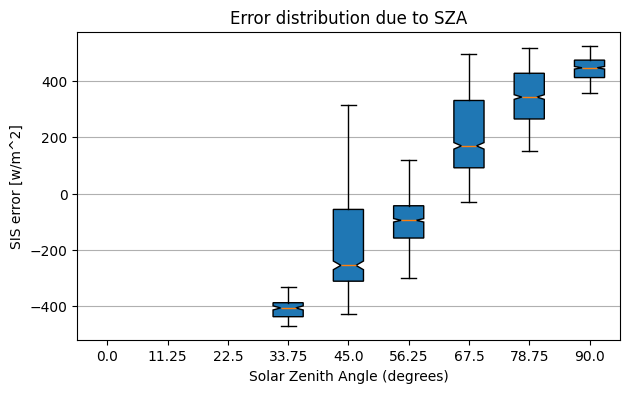

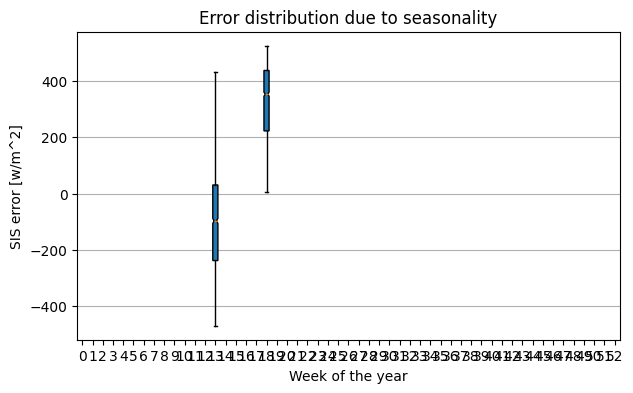

In [8]:
estimator = LitEstimatorPoint(
    config=config,
    learning_rate=0.0001,
)
trainer_sarah.fit(
    estimator, train_dataloaders=train_dataloaders, val_dataloaders=valid_dataloaders,
    # ckpt_path='/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation/tt2pie1v/checkpoints/epoch=30-step=4020.ckpt'
)

In [ ]:
stations = ['CAB', 'CAR', 'CEN' ,'MIL', 'NOR', 'PAL', 'PAY', 'TAB', 'TOR', 'VIS']

test_datasets = [GroundstationDataset(nm, 
                                      config.y_vars, 
                                      config.x_vars, 
                                      config.x_features, 
                                      patch_size=15,
                                      transform=config.transform,
                                      target_transform=config.target_transform) 
                 for nm in stations] 

In [ ]:
test_dataset = torch.utils.data.ConcatDataset(test_datasets)

train_ds, valid_ds = random_split(test_dataset, [0.7, 0.3])

train_dl = DataLoader(train_ds, batch_size=2048, shuffle=True, num_workers= 5)
valid_dl = DataLoader(valid_ds, batch_size=2048, shuffle=False, num_workers=5)